In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from particle import literals as lp

from hnl_apps import *
from hnl_apps.utils_limits import *

In [3]:
channels = [r'$\mu\pi$',
            r'$e^-\pi^+$',
            r'$e^+\pi^-$',
            r'$\mu^+\mu^-$',
            r'$e^+e^-$',]

stop_index_fit = 14

eff_fit = np.zeros(shape=(len(masses_all), 24, 10))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


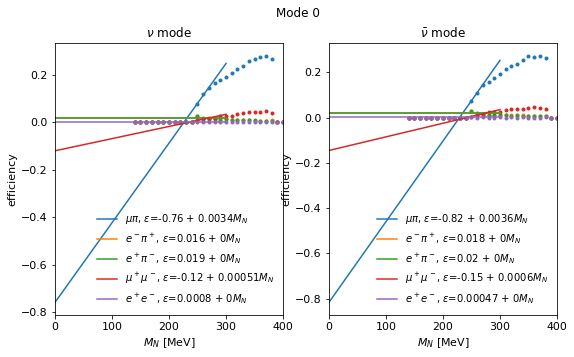

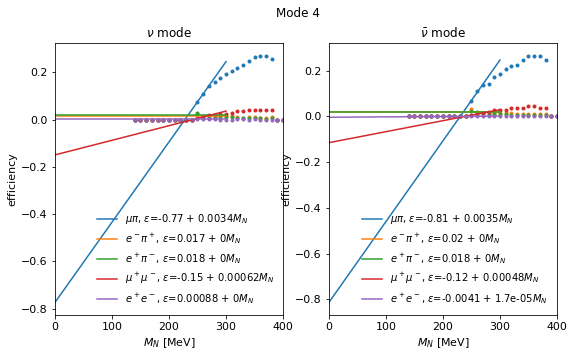

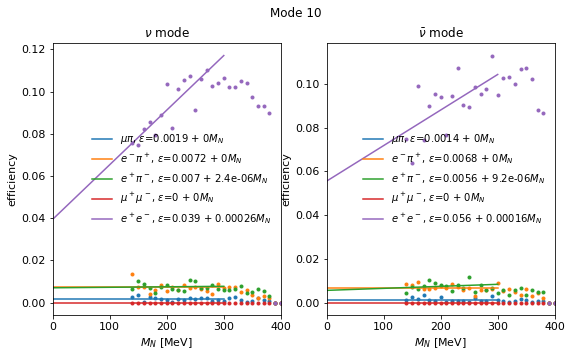

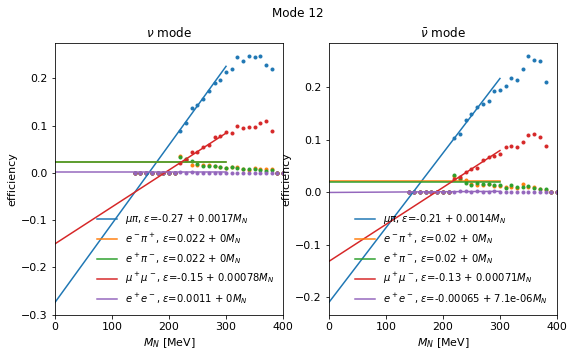

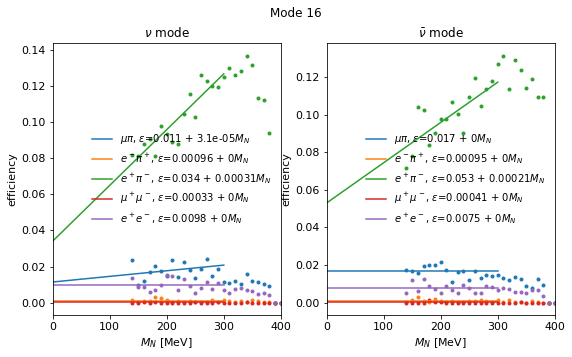

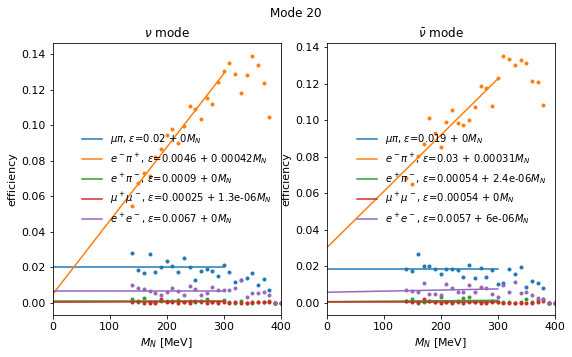

In [4]:
for mode in modes_majorana:
    fig, axs = plt.subplots(1, 2, figsize=(9, 5))

    axs[0].plot(masses_t2k, eff[:, mode, :5], '.')
    axs[1].plot(masses_t2k, eff[:, mode, 5:], '.')

    for i in range(10):
        if i < 5:
            this_ax = axs[0]
        else:
            this_ax = axs[1]
        mask = eff[:stop_index_fit, mode, i]!=0
        if mask.sum() == 0:
            mask = np.ones(len(mask), dtype=bool)
        poly = np.polynomial.polynomial.Polynomial.fit(masses_t2k[:stop_index_fit][mask],
                                                       eff[:stop_index_fit, mode, i][mask],
                                                       deg=1)
        if (poly(1)-poly(0)) < 0:
            poly = np.polynomial.polynomial.Polynomial.fit(masses_t2k[:stop_index_fit][mask],
                                                           eff[:stop_index_fit, mode, i][mask],
                                                           deg=0)
        this_ax.plot(np.linspace(0, 300, 15), 
                     poly(np.linspace(0, 300, 15)), 
                     label=f'{channels[i%5]}, $\epsilon$={poly(0):.2g} + {(poly(1)-poly(0)):.2g}$M_N$',
                     color=f'C{i%5}')

        eff_fit[:, mode, i] = poly(masses_all)

    for i in range(2):
        axs[i].set_xlim(0, 400)
        axs[i].set_xlabel(r'$M_N$ [MeV]')
        axs[i].set_ylabel('efficiency')
        axs[i].legend(frameon=False)
    plt.suptitle(f'Mode {mode}')
    axs[0].set_title(r'$\nu$ mode')
    axs[1].set_title(r'$\bar{\nu}$ mode')
    plt.savefig(f'./plots/efficiencies/mode_{mode}.png', dpi=250, bbox_inches='tight')

In [5]:
hnl_flux = []
for mass in masses_all:
    hnl_flux.append(hnl_tools.get_event_rate((mass/1000, 1e-10),
                                             detector=exp.nd280_fhc,
                                             flavor_struct=[0.0, 1, 0.0],
                                             modes=['nu_e_e', 'nu_e_mu', 'mu_pi', 'nu_mu_mu'],
                                             eff=False)*1e20)
hnl_flux = np.squeeze(np.asarray(hnl_flux))

/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/const.py:150: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(kallen(a,b,c))


In [6]:
flux_fit_dirac = np.zeros((len(masses_all), flux.shape[1]))
flux_fit_majorana = np.zeros((len(masses_all), flux.shape[1]))

flux_fit_dirac[:, 0] = hnl_flux[:, 2]
flux_fit_dirac[:, 4] = hnl_flux[:, 2]
flux_fit_dirac[:, 10] = hnl_flux[:, 0]
flux_fit_dirac[:, 12] = hnl_flux[:, 3]
flux_fit_dirac[:, 16] = hnl_flux[:, 1]

flux_fit_majorana[:, 0] = hnl_flux[:, 2]
flux_fit_majorana[:, 4] = hnl_flux[:, 2]
flux_fit_majorana[:, 10] = hnl_flux[:, 0]*2
flux_fit_majorana[:, 12] = hnl_flux[:, 3]*2
flux_fit_majorana[:, 16] = hnl_flux[:, 1]
flux_fit_majorana[:, 20] = hnl_flux[:, 1]

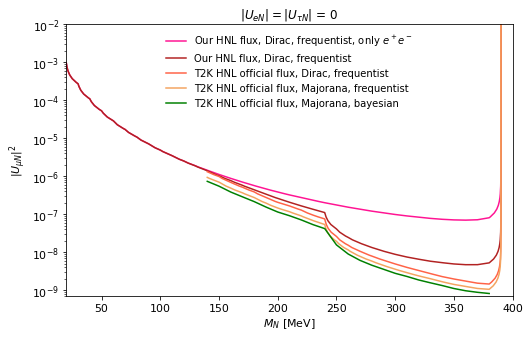

In [13]:
# The final plot
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()

# first canvas
ax.set_title(r'$|U_{eN}| = |U_{\tau N}|$ = 0')

# ax.plot(bound_our_paper[:,0], bound_our_paper[:,1], c='deeppink', lw=1.5, zorder=10, label=r'Fig. 1 this paper (only $e^+e^-$)')

ax.plot(*frequentist_upper_limit(pot_scale_factor*n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=[10]),
                                                          masses=masses_all),
            label=r'Our HNL flux, Dirac, frequentist, only $e^+e^-$',
            color='deeppink')

ax.plot(*frequentist_upper_limit(pot_scale_factor*n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=modes_dirac),
                                                          masses=masses_all),
            label=r'Our HNL flux, Dirac, frequentist',
            color='firebrick')

ax.plot(*frequentist_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_dirac, 
                                                          mode_weights=weights_modes_dirac),
                                                          masses=masses_t2k),
            label=r'T2K HNL official flux, Dirac, frequentist',
            color='tomato')

ax.plot(*frequentist_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_majorana, 
                                                          mode_weights=weights_modes_majorana),
                                                          masses=masses_t2k),
            label=r'T2K HNL official flux, Majorana, frequentist',
            color='sandybrown')

ax.plot(masses_t2k[:-11], nd280_limits_prof[:-11, 2], label='T2K HNL official flux, Majorana, bayesian', color='green')

ax.set_ylabel(r'$|U_{\mu N}|^2$')
ax.set_yscale('log')
ax.set_xlabel(r'$M_N$ [MeV]')
ax.legend(frameon=False)
ax.set_xlim(20, 400)
ax.set_ylim(7e-10, 1e-2)
plt.savefig("plots/plot_supplementary.pdf")

<ipython-input-10-17afac667a06>:16: RuntimeWarning: invalid value encountered in true_divide
  axs[1].plot(masses_t2k, flux_fit_dirac[13:, mode]/(flux[:, mode]*weight), f'C{i}--',
<ipython-input-10-17afac667a06>:16: RuntimeWarning: invalid value encountered in true_divide
  axs[1].plot(masses_t2k, flux_fit_dirac[13:, mode]/(flux[:, mode]*weight), f'C{i}--',
<ipython-input-10-17afac667a06>:16: RuntimeWarning: invalid value encountered in true_divide
  axs[1].plot(masses_t2k, flux_fit_dirac[13:, mode]/(flux[:, mode]*weight), f'C{i}--',
<ipython-input-10-17afac667a06>:16: RuntimeWarning: invalid value encountered in true_divide
  axs[1].plot(masses_t2k, flux_fit_dirac[13:, mode]/(flux[:, mode]*weight), f'C{i}--',


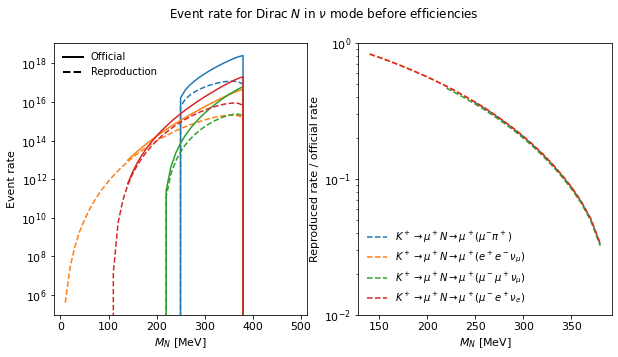

In [10]:
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(r'Event rate for Dirac $N$ in $\nu$ mode before efficiencies')

official_curves = []
reproduction_curves = []
for i, (mode, weight) in enumerate(zip(modes_dirac, weights_modes_dirac)):
    l_official, = axs[0].plot(masses_t2k, flux[:, mode]*weight, f'C{i}', 
                             label=f'ND280 - mode {mode}, weight = {weight}')
    official_curves.append(l_official)
    l_reproduced, = axs[0].plot(masses_all, flux_fit_dirac[:, mode], f'C{i}--', 
                             label=f'Matheus - mode {mode}, weight = {weight}')
    reproduction_curves.append(l_reproduced)

    axs[1].plot(masses_t2k, flux_fit_dirac[13:, mode]/(flux[:, mode]*weight), f'C{i}--', 
                label=modes_latex_strings[mode])

# axs[1].plot([150, 250], [0.85, 0.44], 'k.', label="Ratio of full fluxes")

axs[0].set_ylabel('Event rate')
axs[1].set_ylabel('Reproduced rate / official rate')
axs[1].set_ylim(1e-2,1)

for ax in axs:
    ax.set_xlabel(r'$M_N$ [MeV]')
    ax.set_yscale('log')

legend_elements = [Line2D([0], [0], color='k', lw=2, label='Official'),
                   Line2D([0], [0], color='k', lw=2, ls='dashed', label='Reproduction')]

axs[0].legend(handles=legend_elements, frameon=False)
axs[1].legend(frameon=False)
# fig.savefig("plots/ratio_of_T2K_to_matheus.png", dpi=400)

/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta
/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta
/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta
/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta
/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta
/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta
/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid

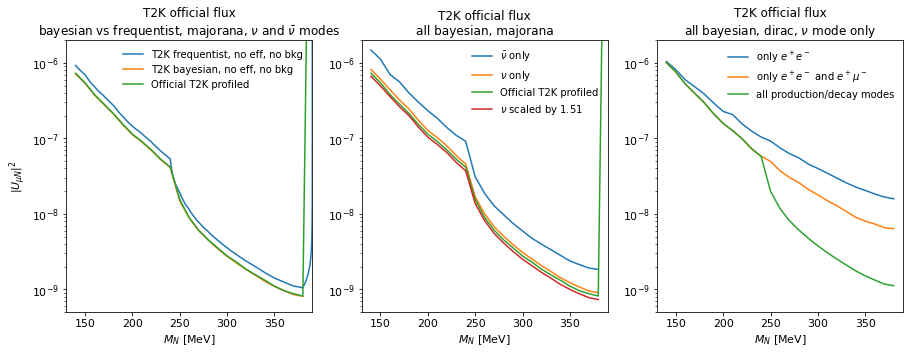

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#first canvas
axs[0].set_title('T2K official flux\nbayesian vs frequentist, majorana, '+r'$\nu$ and $\bar{\nu}$ modes')

axs[0].plot(*frequentist_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_majorana, 
                                                          mode_weights=weights_modes_majorana),
                                                          masses=masses_t2k),
            label=r'T2K frequentist, no eff, no bkg')
axs[0].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_majorana, 
                                                          mode_weights=weights_modes_majorana)),
            label=r'T2K bayesian, no eff, no bkg')
axs[0].plot(masses_t2k, nd280_limits_prof[:, 2], label='Official T2K profiled')


# second canvas
axs[1].set_title('T2K official flux\nall bayesian, majorana')
axs[1].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(5, 10), 
                                                          modes=modes_majorana, 
                                                          mode_weights=weights_modes_majorana)),
            label=r'$\bar{\nu}}$ only')
axs[1].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(5), 
                                                          modes=modes_majorana, 
                                                          mode_weights=weights_modes_majorana)),
            label=r'$\nu$ only')
axs[1].plot(masses_t2k, nd280_limits_prof[:, 2], label='Official T2K profiled')
axs[1].plot(masses_t2k, bayesian_upper_limit(pot_scale_factor*n_events_T2K(eff, flux, 
                                                          channels=np.arange(5), 
                                                          modes=modes_majorana, 
                                                          mode_weights=weights_modes_majorana)),
            label=f'$\\nu$ scaled by {pot_scale_factor:.2f}')

#third canvas
axs[2].set_title('T2K official flux\nall bayesian, dirac, $\\nu$ mode only')
axs[2].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=[10], 
                                                          mode_weights=[0.25])),
            label=r'only $e^+e^-$')
axs[2].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=[10, 16], 
                                                          mode_weights=[0.25, 1])),
            label=r'only $e^+e^-$ and $e^+\mu^-$')
axs[2].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_dirac, 
                                                          mode_weights=weights_modes_dirac)),
            label=r'all production/decay modes')


axs[0].set_ylabel(r'$|U_{\mu N}|^2$')
for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel(r'$M_N$ [MeV]')
    ax.legend(frameon=False)
    ax.set_xlim(130, 390)
    ax.set_ylim(5e-10, 2e-6)

/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:48: UserWarning: No contour levels were found within the data range.
  aux = plt.contour(masses, U2_grid, n_events_grid.T, levels=(threshold,), alpha=0)


IndexError: list index out of range

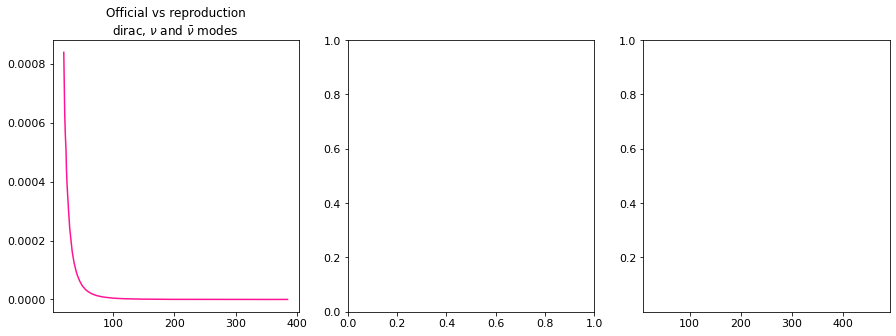

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# first canvas
axs[0].set_title('Official vs reproduction\ndirac, '+r'$\nu$ and $\bar{\nu}$ modes')

axs[0].plot(bound_our_paper[:,0],bound_our_paper[:,1], c='deeppink', lw=1.5, zorder=10, label='T2K our paper')
axs[0].plot(*frequentist_upper_limit(pot_scale_factor*n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(10), 
                                                          modes=modes_dirac),
                                                          masses=masses_all),
            label=r'T2K frequentist, no eff, no bkg')
axs[0].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_dirac, 
                                                          mode_weights=weights_modes_dirac)),
            label=r'T2K bayesian, no eff, no bkg')

# second canvas
axs[1].set_title('Official vs reproduction\nall bayesian, dirac, $\\nu$ mode only')
axs[1].plot(masses_all, bayesian_upper_limit(n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=[10])),
            color='C0',
            label=r'reproduced $e^+e^-$')

axs[1].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(5), 
                                                          modes=[10], 
                                                          mode_weights=[0.25])),
            ls='--',
            color='C0',
            label=r'official $e^+e^-$')

axs[1].plot(masses_all, bayesian_upper_limit(n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=modes_dirac)),
            color='C1',
            label=r'reproduced all')

axs[1].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(5), 
                                                          modes=modes_dirac, 
                                                          mode_weights=weights_modes_dirac)),
            ls='--',
            color='C1',
            label=r'official all')

#third canvas
axs[2].set_title('T2K reproduction\nall bayesian, dirac, $\\nu$ mode only')
axs[2].plot(masses_all, bayesian_upper_limit(n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=[10])),
            label=r'only $e^+e^-$')
axs[2].plot(masses_all, bayesian_upper_limit(n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=[10, 16])),
            label=r'only $e^+e^-$ and $e^+\mu^-$')
axs[2].plot(masses_all, bayesian_upper_limit(n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=modes_dirac)),
            label=r'all production/decay modes')


axs[0].set_ylabel(r'$|U_{\mu N}|^2$')
for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel(r'$M_N$ [MeV]')
    ax.legend(frameon=False)
    ax.set_xlim(0, 390)
    # ax.set_ylim(5e-10, 2e-6)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# first canvas
axs[0].set_title('Official vs reproduction\ndirac, '+r'$\nu$ and $\bar{\nu}$ modes')

axs[0].plot(bound[:,0], bound[:,1], c='deeppink', lw=1.5, zorder=10, label='T2K our paper')
axs[0].plot(*frequentist_upper_limit(pot_scale_factor*n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(10), 
                                                          modes=modes_dirac),
                                                          masses=masses_all),
            label=r'T2K frequentist, no eff, no bkg')
axs[0].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_dirac, 
                                                          mode_weights=weights_modes_dirac)),
            label=r'T2K bayesian, no eff, no bkg')

# second canvas
axs[1].set_title('Official vs reproduction\nall bayesian, dirac, $\\nu$ mode only')
axs[1].plot(masses_all, bayesian_upper_limit(n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=[10])),
            color='C0',
            label=r'reproduced $e^+e^-$')

axs[1].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(5), 
                                                          modes=[10], 
                                                          mode_weights=[0.25])),
            ls='--',
            color='C0',
            label=r'official $e^+e^-$')

axs[1].plot(masses_all, bayesian_upper_limit(n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=modes_dirac)),
            color='C1',
            label=r'reproduced all')

axs[1].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(5), 
                                                          modes=modes_dirac, 
                                                          mode_weights=weights_modes_dirac)),
            ls='--',
            color='C1',
            label=r'official all')

#third canvas
axs[2].set_title('T2K reproduction\nall bayesian, dirac, $\\nu$ mode only')
axs[2].plot(masses_all, bayesian_upper_limit(n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=[10])),
            label=r'only $e^+e^-$')
axs[2].plot(masses_all, bayesian_upper_limit(n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=[10, 16])),
            label=r'only $e^+e^-$ and $e^+\mu^-$')
axs[2].plot(masses_all, bayesian_upper_limit(n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=modes_dirac)),
            label=r'all production/decay modes')


axs[0].set_ylabel(r'$|U_{\mu N}|^2$')
for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel(r'$M_N$ [MeV]')
    ax.legend(frameon=False)
    ax.set_xlim(0, 390)
    # ax.set_ylim(5e-10, 2e-6)

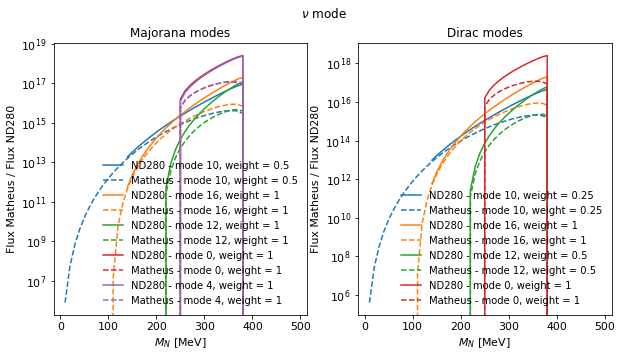

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(r'$\nu$ mode')

for i, (mode, weight) in enumerate(zip([10, 16, 12, 0, 4], [0.5, 1, 1, 1, 1])):
    axs[0].plot(masses_t2k, flux[:, mode]*weight, f'C{i}', label=f'ND280 - mode {mode}, weight = {weight}')
    axs[0].plot(masses_all, flux_fit_majorana[:, mode], f'C{i}--', label=f'Matheus - mode {mode}, weight = {weight}')
    
axs[0].set_title('Majorana modes')

for i, (mode, weight) in enumerate(zip([10, 16, 12, 0], [0.25, 1, 0.5, 1])):
    axs[1].plot(masses_t2k, flux[:, mode]*weight, f'C{i}', label=f'ND280 - mode {mode}, weight = {weight}')
    axs[1].plot(masses_all, flux_fit_dirac[:, mode], f'C{i}--', label=f'Matheus - mode {mode}, weight = {weight}')
axs[1].set_title('Dirac modes')

for ax in axs:
    ax.set_xlabel(r'$M_N$ [MeV]')
    ax.set_ylabel('Flux Matheus / Flux ND280')
    ax.legend(frameon=False)
    ax.set_yscale('log')

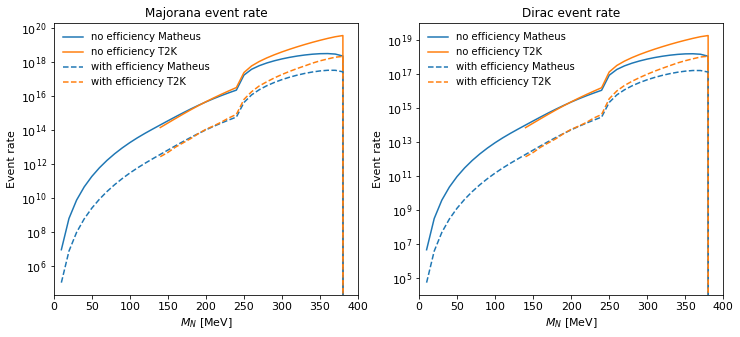

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
pot_factor = (6.29+12.34)/12.34
axs[0].set_title('Majorana event rate')
axs[1].set_title('Dirac event rate')
    
axs[0].plot(masses_all, pot_factor*n_events_T2K(np.ones(eff_fit.shape), flux_fit_majorana, 
                                                          channels=np.arange(5), 
                                                          modes=modes_majorana, 
                                                          mode_weights=np.ones(len(modes_majorana))),
            'C0-', label=r'no efficiency Matheus')
axs[0].plot(masses_t2k, n_events_T2K(np.ones(eff.shape), flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_majorana, 
                                                          mode_weights=weights_modes_majorana),
            'C1-', label=r'no efficiency T2K')
axs[0].plot(masses_all, pot_factor*n_events_T2K(eff_fit, flux_fit_majorana, 
                                                          channels=np.arange(5), 
                                                          modes=modes_majorana, 
                                                          mode_weights=np.ones(len(modes_majorana))),
            'C0--', label=r'with efficiency Matheus')
axs[0].plot(masses_t2k, n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_majorana, 
                                                          mode_weights=weights_modes_majorana),
            'C1--', label=r'with efficiency T2K')



axs[1].plot(masses_all, pot_factor*n_events_T2K(np.ones(eff_fit.shape), flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=modes_dirac, 
                                                          mode_weights=np.ones(len(modes_dirac))),
            'C0-', label=r'no efficiency Matheus')
axs[1].plot(masses_t2k, n_events_T2K(np.ones(eff.shape), flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_dirac, 
                                                          mode_weights=weights_modes_dirac),
            'C1-', label=r'no efficiency T2K')
axs[1].plot(masses_all, pot_factor*n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=modes_dirac, 
                                                          mode_weights=np.ones(len(modes_dirac))),
            'C0--', label=r'with efficiency Matheus')
axs[1].plot(masses_t2k, n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_dirac, 
                                                          mode_weights=weights_modes_dirac),
            'C1--', label=r'with efficiency T2K')

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel(r'$M_N$ [MeV]')
    ax.set_ylabel(r'Event rate')
    ax.legend(frameon=False)
#     ax.set_ylim(1e-9, 1e-6)
    ax.set_xlim(0, 400)

/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta
/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta
/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta
/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta
/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta
/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid value encountered in true_divide
  return erfinv(cl * erf(eta)) / eta
/home/nic/Dropbox/HNLs/stdHNL/hnl_apps/utils_limits.py:42: RuntimeWarning: invalid

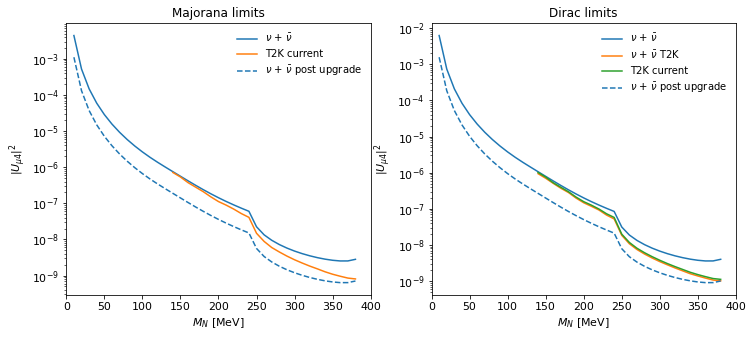

In [153]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title('Majorana limits')
axs[1].set_title('Dirac limits')
    
axs[0].plot(masses_all, bayesian_upper_limit(pot_scale_factor*n_events_T2K(eff_fit, flux_fit_majorana, 
                                                          channels=np.arange(5), 
                                                          modes=modes_majorana, 
                                                          )),
            label=r'$\nu$ + $\bar{\nu}}$')

axs[0].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_majorana, 
                                                          mode_weights=weights_modes_majorana)),
            label=r'T2K current')

axs[0].plot(masses_all, bayesian_upper_limit(volume_upgrade_factor*pot_scale_upgrade_factor*n_events_T2K(eff_fit, flux_fit_majorana, 
                                                          channels=np.arange(5), 
                                                          modes=modes_majorana, 
                                                          )),
            'C0--',
            label=r'$\nu$ + $\bar{\nu}}$ post upgrade')


axs[1].plot(masses_all, bayesian_upper_limit(pot_scale_factor*n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=modes_dirac,)),
            label=r'$\nu$ + $\bar{\nu}}$')

axs[1].plot(masses_t2k, bayesian_upper_limit(pot_scale_factor*n_events_T2K(eff, flux, 
                                                          channels=np.arange(5), 
                                                          modes=modes_dirac, 
                                                          mode_weights=weights_modes_dirac)),
            label=r'$\nu$ + $\bar{\nu}}$ T2K')

axs[1].plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
                                                          channels=np.arange(10), 
                                                          modes=modes_dirac, 
                                                          mode_weights=weights_modes_dirac)),
            label=r'T2K current')

axs[1].plot(masses_all, bayesian_upper_limit(volume_upgrade_factor*pot_scale_upgrade_factor*n_events_T2K(eff_fit, flux_fit_dirac, 
                                                          channels=np.arange(5), 
                                                          modes=modes_dirac,)),
            'C0--',
            label=r'$\nu$ + $\bar{\nu}}$ post upgrade')

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel(r'$M_N$ [MeV]')
    ax.set_ylabel(r'$|U_{\mu 4}|^2$')
    ax.legend(frameon=False)
    ax.set_xlim(0, 400)